<a href="https://colab.research.google.com/github/tarabelo/PIAC-2526/blob/main/Algoritmo%20cu%C3%A1ntico%20variacional%20para%20el%20c%C3%A1lculo%20de%20autovalores%20(VQE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install qiskit[visualization] qiskit-nature pyscf qiskit-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.5/646.5 kB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.1/237.1 kB 14.3 MB/s eta 0:00:00
  Created wheel for docplex: filename=docplex-2.30.251-py3-none-any.whl size=685954 sha256=861092eab1993f418426df3fd4832411007f86f4421df4540e033f99bd585cf3
  Stored in directory: /root/.cache/pip/wheels/c1/d9/5c/1d919b1e441ebbaff244513a13d09c3c0378401601d4184bb0
Successfully built docplex


# **Algoritmo Cuántico Variacional para el cálculo de autovalores (VQE)**

### Contenidos
1. [Principio Variacional](#pv)
1. [Algoritmo VQE](#vqe)
1. [Ejemplo: Problema molecular en Qiskit](#ejemplo)
1. [Optimización con VQE](#optimiza)
1. [Obtención de estados excitados](excitados)

VQE es una generalización de QAOA para aproximar el estado base de un hamiltoniano H genérico.

Se suele usar en problemas de química computacional, por ejemplo, para obtener el mínimo estado de energía de una determinada molécula. También se puede usar en problemas de optimización combinatoria.

Se basa en el principio variacional, que establece que la energía del *ground state* es siempre menor o igual que el valor esperado en cualquier estado arbitrario.

<a name="pv"></a>
# **Principio variacional**
      
Supongamos un estado cuántico, caracterizado por un hamiltoniano $H$ y $E_0$ la energía del estabo base. El principio variacional establece que, para cualquier estado $|\psi\rangle$ se verifica:

$$
E_0 \le \langle H\rangle_{|\psi\rangle} = \langle\psi|H|\psi\rangle
$$

Sea el autoestado $|u_0\rangle$ correspondiente al autovalor $E_0$. Para cualquier otro autovalor $E_i$ se tiene que:

\begin{align*}
    E_0 \le E_i = \langle H \rangle_{|u_i\rangle} = \langle u_i |H|u_i \rangle
\end{align*}  

Sea un estado arbitrario $|\psi\rangle$. Escribiendo $H$ en la base de sus autoestados $H = \sum_{i=1}^N E_i |u_i\rangle\langle u_i|$ tenemos que el valor esperado de la energía en el estado $|\psi\rangle$:

\begin{align}
E(|\psi\rangle)=\langle H\rangle_{|\psi\rangle} = \langle \psi |H|\psi \rangle & = \
 \langle \psi | \left( \sum_{i=1}^N E_i |u_i\rangle\langle u_i| \right) |\psi \rangle\\
 &= \sum_{i=1}^N E_i \langle \psi |u_i\rangle\langle u_i|\psi \rangle\\
 &= \sum_{i=1}^N E_i |\langle u_i|\psi \rangle|^2
\end{align}

Es decir, el valor esperado de $H$ en un estado cualquiera es una combinación lineal en la que los autovalores actúan como pesos. De esta expresión es facil ver que:

\begin{align}
    \langle H \rangle_{|\psi\rangle} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} E_i | \langle u_i | \psi\rangle |^2 \ge  \sum_{i = 1}^{N} E_0 | \langle u_i | \psi\rangle |^2 = E_0 \sum_{i = 1}^{N} | \langle u_i | \psi\rangle |^2 = E_0
\end{align}

Esa expresión se denomina _principio variacional_ y simplemente indica que el valor mínimo de energía es menor o igual que el valor esperado de $H$ en un estado arbitrario.




---



---



---



<a name="vqe"></a>
# **Algoritmo VQE**


VQE (Peruzzo, et al. 2014) aproxima el estado base de un hamiltoniano H. Para ello se crea un circuito cuántico variacional (denominado _forma variacional_ o _ansatz_) en un estado inicial $|\psi\rangle$. Ejecutando el circuito, se obtiene el valor esperado $\langle H \rangle_{|\psi\rangle}$. Se usa un  optimizador clásico para ajustar los parámetros del circuito con con vistas a encontrar los parámetros que minimicen $\langle H \rangle_{|\psi\rangle}$.

<center><img src="https://drive.google.com/uc?export=view&id=1O9RXUnTfu09PLD7O4XT1FrC2GcSE008t" alt="Circuito variacional" width="900"  /></center>


La idea de VQE es, partiendo del estado inicial, ir recorriendo el espacio de estados (o lo que es lo mismo, la esfera de Bloch) y calcular el valor esperado en $H$ en cada estado, ajustando el ansatz para biuscar el mínimo.

Por ejemplo, se podría elegir como valor inicial el estado $|0\rangle$ e ir aplicando rotaciones $R_Y$ o $R_x$:

<center><img src="https://drive.google.com/uc?export=view&id=1y94qu2xOloSXoTe-8t9nwgehEvgfZHG1" alt="VQE" width="200"  /></center>
(Fuente: <a href=https://www.mustythoughts.com/variational-quantum-eigensolver-explained>https://www.mustythoughts.com/variational-quantum-eigensolver-explained</a>)

En general, se usan ansätze $V(\theta)$ más complejos que permitan recorrer la esfera de Bloch.


## Pseudocódigo VQE

El algoritmo VQE parte de un Hamiltoniano $H$, cuyo estado base resuelve el problema, y procede como sigue:

1. Se elige un estado inicial (normalmente $|\psi(\theta)\rangle = |0\rangle$) y un _ansatz_ $V(\theta)$
2. Se le dan valores iniciales a los parámetros $\theta$
2. En la QPU se ejecuta el ansatz con esos parámetros para obtener un estado $|\psi(\theta)\rangle = V(\theta)|0\rangle$
3. Se mide el valor esperado del Hamiltoniano en ese estado $\langle\psi(\theta)|H|\psi(\theta)\rangle$
4. En la CPU se usa un algoritmo de optimización para modificar los parámetros del ansatz
    - Objetivo: reducir el valor esperado del Hamiltoniano
5. Se vuelve al paso 3 hasta que se alcanza un mínimo

Igual que en QAOA, el proceso de optimización de los parámetros puede ser un simple gradiente descendente, en el que cada parámetro se actualiza en la dirección que conduzca al mayor descenso de la energía, u otros método de optimización más sofisticados.


## Obtención del valor esperado

A diferencia del QAOA, en el que el Hamiltoniano es una matriz diagonal, en VQE es más general $\implies$ no es trivial obtener el valor esperado.

Solución: Expresar el Hamiltoniano como suma de productos tensor de matrices de Pauli y obtener el valor esperado tomando medidas en diferentes bases.

## Ejemplos de ansätze

La elección de la forma variacional o ansatz para VQE depende del hardware disponible o del problema a tratar. Un ejemplo es [_RealAmplitudes_](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.real_amplitudes) que vimos antes. Otro ansatz es el [_EfficientSU2_](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.efficient_su2).

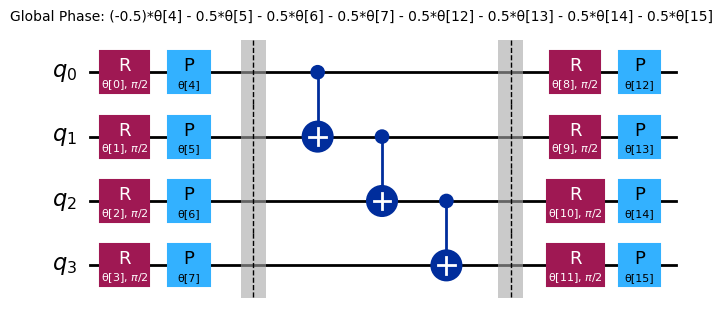

In [4]:
from qiskit.circuit.library import efficient_su2

ansatz = efficient_su2(num_qubits=4, reps=1, entanglement='linear', insert_barriers=True)

ansatz.decompose().draw('mpl')

<a name="ejemplo"></a>
# **Ejemplo: problema molecular en Qiskit**

VQE se puede utilizar para calcular la energía del estado base de una molécula.

El paquete [Qiskit Nature](https://qiskit-community.github.io/qiskit-nature/) proporciona herramientas para definir un problema de este tipo.

Utiliza la librería de química cuántica [pyscf](https://pyscf.org/)



In [ ]:
import qiskit_nature
print(qiskit_nature.__version__)

**Ejemplo**: obtener la energía del estado base de una molécula de hidrógeno

Empezamos definiendo la molécula y obteniendo el hamiltoniano fermiónico, que describe la energía de la molécula de H$_2$

In [ ]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

# Definimos la molécula H_2
molecule = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)], charge=0, multiplicity=1)

# Creo un Driver PySCF
driver = PySCFDriver.from_molecule(molecule, basis="sto3g")

# Creo el problema
problem = driver.run()

# Obtengo el hamiltoniano fermiónico usando second quantization
fhamiltonian = problem.hamiltonian.second_q_op()

print(fhamiltonian)

Transformamos el hamiltoniano fermiónico en un _qubit hamiltonian_ usando la [transformación Jordan-Wigner](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation):

In [ ]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

qhamiltonian = mapper.map(fhamiltonian)

print(qhamiltonian)

Definimos un ansatz para VQE. Podemos usar el _EfficientSU2_ con 1 repetición y entaglement linear.

In [ ]:
from qiskit.circuit.library import efficient_su2

ansatz = efficient_su2(num_qubits=qhamiltonian.num_qubits, reps=1, entanglement='linear', insert_barriers=True)

ansatz.decompose().draw('mpl')

Resolvemos usando VQE y el optimizador clásico [L_BFGS_B](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.L_BFGS_B.html#qiskit_algorithms.optimizers.L_BFGS_B) definido en [`qiskit_algorithms.optimizers`](https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html)

In [ ]:
import numpy as np
from qiskit_algorithms import VQE
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_algorithms.optimizers import L_BFGS_B

# Definimos el optimizador clásico
optimizer = L_BFGS_B()

# Creamos el estimador
estimator = Estimator()

# Definimos la instancia VQE
vqe = VQE(estimator, ansatz, optimizer)

# Establecemos valores aleatorios iniciales de los parámetos del ansatz
vqe.initial_point = np.random.random(ansatz.num_parameters)

# Obtenemos el menor autovalor del qhamiltoniano
result = vqe.compute_minimum_eigenvalue(qhamiltonian)

print(result)

In [ ]:
print('Energía del estado base = {}'.format(result.eigenvalue))

El ansatz sustituyendo los parámetros del punto óptimo:

In [ ]:
# 1. Bind de parámetros óptimos en el circuito óptimo
opt_circuit = result.optimal_circuit.assign_parameters(result.optimal_parameters)

opt_circuit.draw('mpl')


Obtenemos el estado base:

In [ ]:
from qiskit.quantum_info import Statevector

# Obtener el statevector del ground state
ground_state = Statevector.from_instruction(opt_circuit)

print(ground_state)

En https://quantum.cloud.ibm.com/learning/en/courses/quantum-chem-with-vqe podéis ver ejemplos más complejos de química cuántica con VQE en Qiskit



---



---



---



<a name="optimiza"></a>
# **Optimización con VQE**

VQE puede usarse para resolver problemas de optimización en vez de QAOA, ya que también busca minimizar un Hamiltoniano.

Podemos usar diferentes ansätze que pueden dar lugar a circuitos más eficientes.

Un ansatz eficiente debería:

- Minimizar el número de puertas y la profuncidad del circuito.
- Usar preferiblemente las puertas nativas del hardware
- Ser robusto frente al fenómeno de los *barren plateaus*.

Los ansätze mas usados se pueden clasificar, grosso modo, en:

- Hardware-efficient ansätze: pensados para adaptarse al hardware disponible.
- Problem-inspired Ansätze:  especialmente adaptados al problema a resolver (por ejemplo, el del QAOA).

### **Ejemplo**: Usa VQE para encontrar el mínimo de energía del Hamiltoniano Ising:

$$
H_c = 3Z_2Z_0 - Z_2Z_1 + 2Z_0
$$

Este problema lo resolvimos con QAOA y encontramos que el mínimo está en el estado $|001\rangle$ con $E_0 = -6$.



In [6]:
from qiskit.quantum_info import SparsePauliOp

# Expresamos el problema como un operador Hamiltoniano
Hc = SparsePauliOp.from_list([("ZIZ", 3), ("ZZI", -1), ("IIZ", 2)])
print(Hc)

SparsePauliOp(['ZIZ', 'ZZI', 'IIZ'],
              coeffs=[ 3.+0.j, -1.+0.j,  2.+0.j])


Vamos a resolverlo usando la implementación [SamplingVQE](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.SamplingVQE.html) que es una versión de VQE optimizada para Hamiltonianos diagonales.

Como ansatz usaremos RealAmplitudes

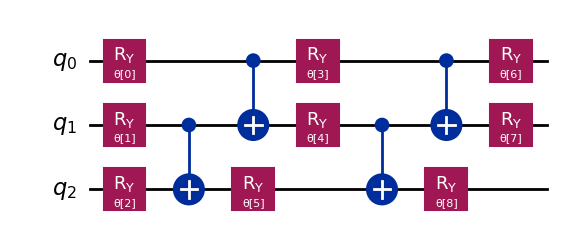

In [8]:
from qiskit.circuit.library import real_amplitudes
ansatz = real_amplitudes(num_qubits=Hc.num_qubits,  reps=2)
ansatz.draw('mpl')

In [12]:
import numpy as np
from qiskit_algorithms import SamplingVQE
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 10598

# Utilizo el optimizador COBYLA
optimizer = COBYLA()

# Defino el Sampler
sampler = StatevectorSampler()

# Defino el algoritmo
vqe = SamplingVQE(sampler=sampler, ansatz=ansatz, optimizer=optimizer)

# Establecemos valores aleatorios iniciales de los parámetos del ansatz
vqe.initial_point = np.random.random(ansatz.num_parameters)

# Obtengo el mínimo autovalor del Hamiltoniano
result = vqe.compute_minimum_eigenvalue(Hc)

print(result)
#min_state = result.best_measurement['bitstring']
#ev = result.best_measurement['value']
#print("Estado que minimiza Hc = {}".format(min_state))
#print("Valor esperado <{}|Hc|{}> = {}\n".format(min_state, min_state, ev.real))

{   'aux_operators_evaluated': None,
    'best_measurement': {   'bitstring': '001',
                            'probability': 0.9892578125,
                            'state': 1,
                            'value': np.complex128(-6+0j)},
    'cost_function_evals': 75,
    'eigenstate': {   '000': 0.0009765625,
                      '001': 0.98046875,
                      '010': 0.001953125,
                      '011': 0.0029296875,
                      '100': 0.0126953125,
                      '101': 0.0009765625},
    'eigenvalue': np.float64(-5.94140625),
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7d4af3720410>,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): np.float64(0.18159674995067465),
                              ParameterVectorElement(θ[0]): np.float64(1.9765219373834133),
                              ParameterVectorElement(θ[2]): np.float64(1.3523157121805045),
                              ParameterVectorElement(θ[

In [14]:
print("Minima energía = {}".format(result.eigenvalue))
print("Estado base: {}".format(result.eigenstate))

Minima energía = -5.94140625
Estado base: {'001': 0.98046875, '100': 0.0126953125, '010': 0.001953125, '011': 0.0029296875, '000': 0.0009765625, '101': 0.0009765625}




---



---



---



<a name="ejercicio8"></a>
# **Ejercicio 8: el problema del viajante de comercio**.

El Problema del Viajante de Comercio (_Travelling Salesman Problem_, TSP) es un problema clásico de optimización combinatoria. Consiste en encontrar la ruta más corta que permita a un viajante visitar un conjunto de ciudades exactamente una vez cada una y regresar al punto de partida.

A cada par de ciudades se les asigna un coste de viaje (distancia, tiempo, energía, etc.), y el objetivo es determinar el recorrido de coste total mínimo.

Desde el punto de vista computacional, el TSP es un problema NP-hard, lo que implica que no se conoce un algoritmo eficiente que encuentre siempre la solución óptima en tiempo polinómico para instancias grandes.

El TSP es fundamental en áreas como logística, planificación de rutas, diseño de circuitos electrónicos, bioinformática y optimización industrial, y constituye uno de los ejemplos más ilustrativos de los retos y técnicas utilizadas en la optimización discreta.

El TSP puede modelarse de manera natural mediante la teoría de grafos. Cada ciudad se representa como un nodo de un grafo y cada posible conexión entre dos ciudades se modela como una arista con un peso, que corresponde al coste de viajar entre ellas (distancia, tiempo, coste económico, etc.).

Si el viajante puede viajar en ambas direcciones entre dos ciudades con el mismo coste, se emplea un grafo no dirigido y ponderado. Si los costes difieren según la dirección del viaje, el modelo es un grafo dirigido y ponderado.

En este marco, el TSP consiste en encontrar un ciclo hamiltoniano de coste mínimo dentro del grafo. Un ciclo hamiltoniano es un camino cerrado que visita cada nodo exactamente una vez y vuelve al punto de inicio.


Supongamos el grafo $G=(V,E)$ con $n=|V|$ nodos y distancias (pesos) $w_{ij}$. Un ciclo hamiltoniano se describe mediante $n^2$ variables binarias $x_{i,p}$ que cumplen:

$$
x_{i,p} =
\begin{cases}
1 & \text{si la ciudad } i\in\{0,\dots,n-1\} \text{ ocupa la posición } p\in\{0,\dots,n-1\},\\
0 & \text{en otro caso.}
\end{cases}
$$


La función de objetivo a minimizar es:

$$
C(x) = \sum_{p=0}^{n-1} \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} w_{i,j} \; x_{i,p} \; x_{j,(p+1) \bmod n}
$$


#### Restricciones

1. En cada paso $p$ solo podemos estar un una ciudad (vértice), es decir:

$$
\sum_{i=0}^{n-1} x_{i,p} = 1, \quad \forall p=0,\dots,n-1
$$

2. Cada ciudad se visite una y solo una vez, es decir:

$$
\sum_{p=0}^{n-1} x_{i,p} = 1, \quad \forall i=0,\dots,n-1
$$

Vamos a suponer que el grafo está totalmente conectado (hay rutas entre todas las ciudades). Si no es así, necesitamos una restricción adicional que eviten las rutas no disponibles.


La función objetivo incluyendo las restricciones queda::


$$
\mathcal{L}(x, \lambda, \mu) =
\sum_{p=0}^{n-1} \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} w_{i,j} \; x_{i,p} \; x_{j,(p+1)\bmod n}
+ \sum_{p=0}^{n-1} \lambda_p \left(\sum_{i=0}^{n-1} x_{i,p} - 1 \right)
+ \sum_{i=0}^{n-1} \mu_i \left(\sum_{p=0}^{n-1} x_{i,p} - 1 \right)
$$

donde $\lambda$ y $\mu$ deben ser lo suficientemente grandes para forzar a que se cumplan las restricciones.

## Problema TSP en Qiskit

El TSP también está disponible en [`qiskit_optimization.applications`](https://qiskit-community.github.io/qiskit-optimization/apidocs/qiskit_optimization.applications.html).

Distancias
 [[ 0. 39. 15. 62. 60.]
 [39.  0. 34. 48. 25.]
 [15. 34.  0. 47. 50.]
 [62. 48. 47.  0. 37.]
 [60. 25. 50. 37.  0.]]


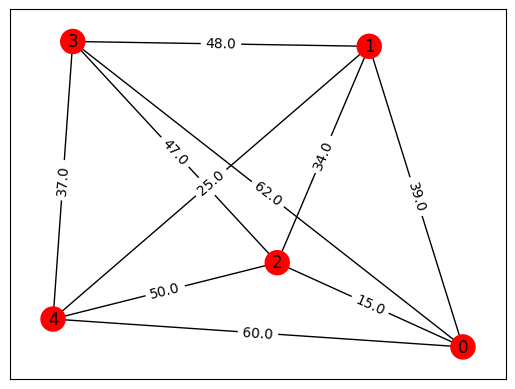

In [35]:
import networkx as nx
import numpy as np
import matplotlib as plt
from qiskit_optimization.applications import Tsp

n = 5
tsp = Tsp.create_random_instance(n, seed=5365)
G = tsp.graph

adj_matrix = nx.to_numpy_array(G)
print("Distancias\n", adj_matrix)

# Mostramos el grafo
layout = nx.random_layout(G,seed=10)
colors = ["r" for node in tsp.graph.nodes]
nx.draw_networkx(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

El siguiente código encuentra la mejor ruta probando todas:

In [36]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            #print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)

Best order from brute force = (0, 1, 4, 3, 2) with total distance = 163.0


**EJERCICIO**:

Resuelve el problema usando SamplingVQP y un ansazt [`n-local`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.n_local) con puertas $R_y$ como puertas de rotación y C-Phase como bloques de entrelazamiento.





---



---



---



<a name="excitados"></a>
# **Obtención de estados excitados**

El algoritmo VQD (_Variational Quantum Deflaction_) es una extensión del VQE que permite obtener _estados excitados_, es decir, autoestados con mayor energía.

Para ello, si $|\psi_0\rangle$ es el estado base, es posible demostrar que el estado base del siguiente Hamiltoniano:

$$
H' = H + C|\psi_0\rangle\langle\psi_0|
$$
es el primer estado excitado de H

#### Referencias:

  - Peruzzo, et al. (2014). A variational eigenvalue solver on a photonic quantum processor. Nature communications, 5(1), 1-7. [arXiv:1304.3061](https://arxiv.org/abs/1304.3061)
  - Higgott, O., Wang, D., & Brierley, S. (2019). Variational quantum computation of excited states. Quantum, 3, 156. [arXiv:1805.08138](https://arxiv.org/abs/1805.08138)
  - Combarro, E.F. & Gonzákez-Castillo, S. (2023). A Practical Guide  to Quantum Machine Learning and Quantum Optimization, capítulo  7. Packt.
  - Qiskit tutorial: Variational quantum eigensolver https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver




---



---



---

